# Optimal Control

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import qutip_qtrl.pulseoptim as cpo
import scqubits as scq

In [92]:
levels = 6
fluxonium = scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux=0.48, cutoff=110)
c_ops = None  # will be initialized once below

In [93]:
def init_c_ops():
    gamma_ij = {}
    for j in range(1, levels):
        for i in range(j):
            t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5, total=False)
            if t1 is not None and t1 > 0:
                rate = 1.0 / t1
                gamma_ij[(i, j)] = rate
                gamma_ij[(j, i)] = rate
    c_ops_local = []
    for (i, j), gamma in gamma_ij.items():
        cop = np.sqrt(gamma) * qt.basis(levels, i) * qt.basis(levels, j).dag()
        c_ops_local.append(cop)
    return c_ops_local

In [94]:
scq.settings.T1_DEFAULT_WARNING=False


if c_ops is None:
    c_ops = init_c_ops()

evals, evecs = fluxonium.eigensys(evals_count=levels)
n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
H0 = qt.Qobj(np.diag(evals))
A = 0.1
drive_op = n_op_energy_basis
H = [H0, [A * drive_op, 'cos(wd * t)']]

In [95]:
def evolve(omega_d, t_g):
    # global c_ops
    # if c_ops is None:
    #     c_ops = init_c_ops()

    # evals, evecs = fluxonium.eigensys(evals_count=levels)
    # n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
    # H0 = qt.Qobj(np.diag(evals))
    # A = 0.1
    # drive_op = n_op_energy_basis
    # H = [H0, [A * drive_op, 'cos(wd * t)']]
    args = {'wd': omega_d}
    options = qt.Options(nsteps=1000000, store_states=True, atol=1e-10, rtol=1e-9)

    propagator = qt.propagator(H, t_g, args=args, options=options, c_ops=c_ops)
    propagator_kraus = qt.to_kraus(propagator)
    propagator_2x2 = [qt.Qobj(k.full()[:2, :2]) for k in propagator_kraus]
    p_2x2_super = qt.kraus_to_super(propagator_2x2)
    fidelity = qt.average_gate_fidelity(p_2x2_super, qt.sigmax())
    print("completed iteration")
    return fidelity

def wrapped_evolve(args):
    return evolve(*args)


-------------------

## Example Notebook

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
# the library for quantum control
import qutip_qtrl.pulseoptim as cpo

In [97]:
# total duration
T = 2 * np.pi
# number of time steps
times = np.linspace(0, T, 1000)

In [98]:
U_0 = qt.operators.identity(4)
U_target = qt.core.gates.cnot()

In [99]:
# Drift Hamiltonian
g = 0
H_drift = g * (
    qt.tensor(qt.sigmax(), qt.sigmax()) + qt.tensor(qt.sigmay(), qt.sigmay())
)

In [100]:
H_ctrl = [
    qt.tensor(qt.sigmax(), qt.identity(2)),
    qt.tensor(qt.sigmay(), qt.identity(2)),
    qt.tensor(qt.sigmaz(), qt.identity(2)),
    qt.tensor(qt.identity(2), qt.sigmax()),
    qt.tensor(qt.identity(2), qt.sigmay()),
    qt.tensor(qt.identity(2), qt.sigmaz()),
    qt.tensor(qt.sigmax(), qt.sigmax()),
    qt.tensor(qt.sigmay(), qt.sigmay()),
    qt.tensor(qt.sigmaz(), qt.sigmaz()),
]

In [101]:
H_labels = [
    r"$u_{1x}$",
    r"$u_{1y}$",
    r"$u_{1z}$",
    r"$u_{2x}$",
    r"$u_{2y}$",
    r"$u_{2z}$",
    r"$u_{xx}$",
    r"$u_{yy}$",
    r"$u_{zz}$",
]

In [102]:
result = cpo.optimize_pulse_unitary(
    H_drift,
    H_ctrl,
    U_0,
    U_target,
    num_tslots=1000,
    evo_time=(2 * np.pi),
    # this attribute is crucial for convergence!!
    amp_lbound=-(2 * np.pi * 0.05),
    amp_ubound=(2 * np.pi * 0.05),
    fid_err_targ=1e-9,
    max_iter=1000,
    max_wall_time=60,
    alg="GRAPE",
    optim_method="FMIN_L_BFGS_B",
    method_params={
        "disp": True,
        "maxiter": 1000,
    },
)

In [103]:
for attr in dir(result):
    if not attr.startswith("_"):
        print(f"{attr}: {getattr(result, attr)}")

print(np.shape(result.final_amps))

evo_full_final: Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.07097199e-01-7.07116362e-01j  1.72681494e-05-2.08382309e-05j
   1.60210893e-06+5.99484126e-06j -4.69341228e-06-1.00812277e-05j]
 [-2.08384889e-05+1.72683975e-05j  7.07114982e-01-7.07098579e-01j
   1.18680893e-05+6.59482868e-06j -1.37287176e-06-2.85651492e-05j]
 [-1.00803957e-05-4.69326908e-06j -2.85651606e-05-1.37335348e-06j
   9.71343000e-07-1.94051817e-05j  7.07110108e-01-7.07103453e-01j]
 [ 5.99480370e-06+1.60187376e-06j  6.59528297e-06+1.18685678e-05j
   7.07104834e-01-7.07108728e-01j -1.94047660e-05+9.71337157e-07j]]
evo_full_initial: Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 9.88916683e-01-0.1096191j  -3.32300084e-02+0.00562851j
  -7.94159022e-02+0.04804015j  7.31815642e-05-0.01663692j]
 [ 3.69055059e-02-0.00021943j  9.90305211e-01+0.07395414j
   1.67611276e-03-0.07091502j -8.11747630e-02+0.0290382j ]
 [ 

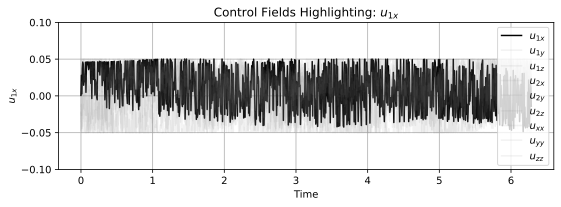

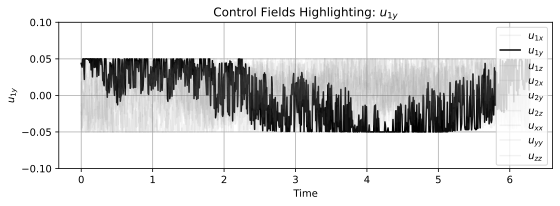

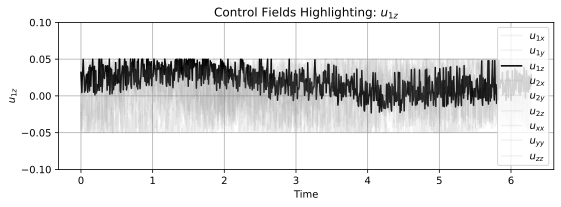

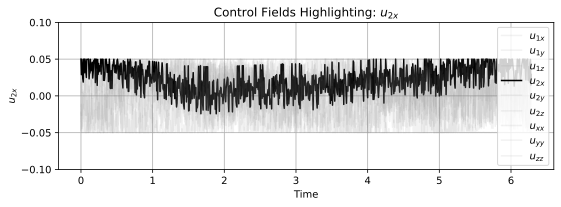

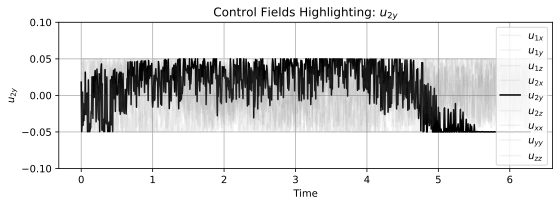

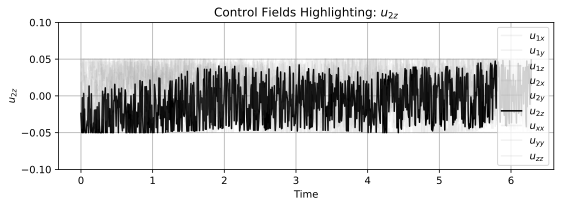

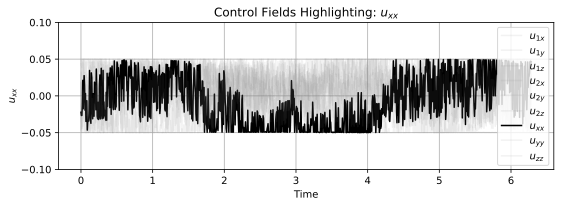

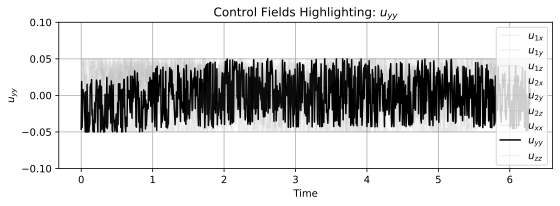

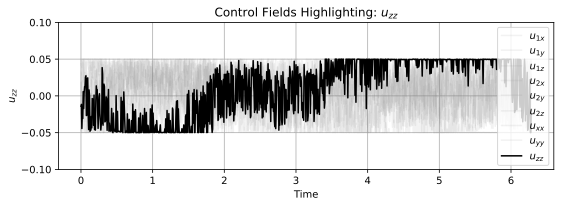

In [104]:
def plot_control_amplitudes(times, final_amps, labels):
    num_controls = final_amps.shape[1]

    y_max = 0.1  # Fixed y-axis scale
    y_min = -0.1

    for i in range(num_controls):
        fig, ax = plt.subplots(figsize=(8, 3))

        for j in range(num_controls):
            # Highlight the current control
            color = "black" if i == j else "gray"
            alpha = 1.0 if i == j else 0.1
            ax.plot(
                times,
                final_amps[:, j],
                label=labels[j],
                color=color,
                alpha=alpha
                )
        ax.set_title(f"Control Fields Highlighting: {labels[i]}")
        ax.set_xlabel("Time")
        ax.set_ylabel(labels[i])
        ax.set_ylim(y_min, y_max)  # Set fixed y-axis limits
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()


plot_control_amplitudes(times, result.final_amps / (2 * np.pi), H_labels)

In [105]:
U_target

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [106]:
U_f = result.evo_full_final
U_f.dims = [[2, 2], [2, 2]]

In [107]:
U_f

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.07097199e-01-7.07116362e-01j  1.72681494e-05-2.08382309e-05j
   1.60210893e-06+5.99484126e-06j -4.69341228e-06-1.00812277e-05j]
 [-2.08384889e-05+1.72683975e-05j  7.07114982e-01-7.07098579e-01j
   1.18680893e-05+6.59482868e-06j -1.37287176e-06-2.85651492e-05j]
 [-1.00803957e-05-4.69326908e-06j -2.85651606e-05-1.37335348e-06j
   9.71343000e-07-1.94051817e-05j  7.07110108e-01-7.07103453e-01j]
 [ 5.99480370e-06+1.60187376e-06j  6.59528297e-06+1.18685678e-05j
   7.07104834e-01-7.07108728e-01j -1.94047660e-05+9.71337157e-07j]]

In [108]:
print(f"Fidelity: {qt.process_fidelity(U_f, U_target)}")


Fidelity: 0.9999999987758708


---------------------

## New Data

"need to be careful when truncating the dimension to calculate the fidelity, but to start with I can make a system with three levels where U ideal is X on the lowest two and then identity on the last one"

In [166]:
levels = 6
fluxonium = scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux=0.48, cutoff=110)

In [167]:
evals, evecs = fluxonium.eigensys(evals_count=levels)

n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))

H0 = qt.Qobj(np.diag(evals))
# A = 0.1
A = 0.4 * 2 * np.pi


H_ctrl = [n_op_energy_basis] # all from the previous code

In [168]:
U_0 = qt.qeye(levels)
U_0

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dia, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

In [169]:
# U_target = qt.Qobj([[0, 1, 0],
#          [1, 0, 0],
#          [0, 0, 1]])

# Create a target unitary that is an X gate on the lowest two levels and identity on the rest
U_target = qt.qeye(levels).full()
U_target[0, 0] = 0
U_target[1, 1] = 0
U_target[0, 1] = 1
U_target[1, 0] = 1
U_target = qt.Qobj(U_target)

#done manually to make it easier to read, not scalable at the moment

U_target

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

In lab frame: ctrl = f(t) representing drive n hat (charge op)

eigenenergy frame: n fransformed into H drive (only control we have)

In [170]:
H_drift = H0

H_drift

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-0.70018338  0.          0.          0.          0.          0.        ]
 [ 0.         -0.1893103   0.          0.          0.          0.        ]
 [ 0.          0.          8.75185302  0.          0.          0.        ]
 [ 0.          0.          0.         11.70704503  0.          0.        ]
 [ 0.          0.          0.          0.         16.50117828  0.        ]
 [ 0.          0.          0.          0.          0.         17.51911783]]

### Actually results run

    H_d : Qobj or list of Qobj
        Drift (aka system) the underlying Hamiltonian of the system
        can provide list (of length num_tslots) for time dependent drift
    H_c : Qobj
        a list of control Hamiltonians. These are scaled by
        the amplitudes to alter the overall dynamics
    U_0 : Qobj
        starting point for the evolution.
        Typically the identity matrix
    U_targ : Qobj
        target transformation, e.g. gate or state, for the time evolution


In [171]:
# result = cpo.optimize_pulse_unitary(
#     H_drift, #H_0
#     H_ctrl, #drive op in eigenbasis
#     U_0, #identity
#     U_target,
#     num_tslots=1000,
#     evo_time=(2 * np.pi),
#     amp_lbound=-(2 * np.pi * 0.05),
#     amp_ubound=(2 * np.pi * 0.05),
#     fid_err_targ=1e-9,
#     max_iter=1000,
#     max_wall_time=60,
#     alg="GRAPE",
#     optim_method="FMIN_L_BFGS_B",
#     method_params={
#         "disp": True,
#         "maxiter": 1000,
#     },
# )

# #look at the documentation to confirm U_0

In [172]:
result = cpo.optimize_pulse_unitary(
    H_drift, #H_0
    H_ctrl, #drive op in eigenbasis
    U_0, #identity
    U_target,
    num_tslots=1000,
    evo_time=(2 * np.pi),
    amp_lbound=None,
    amp_ubound=None,
    fid_err_targ=1e-9,
    max_iter=1000,
    max_wall_time=20,
    alg="GRAPE",
    optim_method="FMIN_L_BFGS_B",
    method_params={
        "disp": True,
        "maxiter": 1000,
    },
)

#look at the documentation to confirm U_0

In [173]:
# result.final_amps

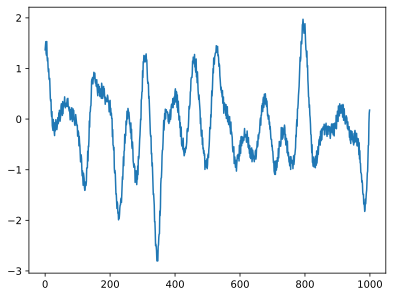

In [174]:
plt.plot(result.final_amps / (2 * np.pi))


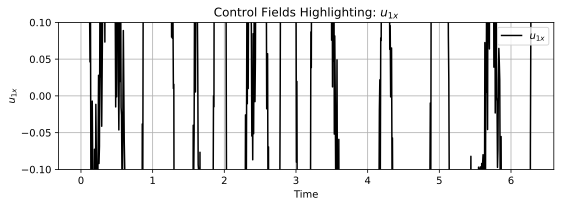

In [ ]:
# def plot_control_amplitudes(times, final_amps, labels):
#     num_controls = final_amps.shape[1]

#     y_max = 0.1  # Fixed y-axis scale
#     y_min = -0.1

#     for i in range(num_controls):
#         fig, ax = plt.subplots(figsize=(8, 3))

#         for j in range(num_controls):
#             # Highlight the current control
#             color = "black" if i == j else "gray"
#             alpha = 1.0 if i == j else 0.1
#             ax.plot(
#                 times,
#                 final_amps[:, j],
#                 label=labels[j],
#                 color=color,
#                 alpha=alpha
#                 )
#         ax.set_title(f"Control Fields Highlighting: {labels[i]}")
#         ax.set_xlabel("Time")
#         ax.set_ylabel(labels[i])
#         ax.set_ylim(y_min, y_max)  # Set fixed y-axis limits
#         ax.grid(True)
#         ax.legend()
#         plt.tight_layout()
#         plt.show()

# plot_control_amplitudes(times, result.final_amps / (2 * np.pi), H_labels)

In [176]:
U_f = result.evo_full_final


In [177]:
U_f

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-7.41618482e-05+4.18508268e-05j -9.95587435e-01+9.38382779e-02j
  -1.13133564e-05-4.72394828e-05j  2.23066366e-05+1.02919603e-04j
   2.32775070e-05-5.34919753e-05j  7.56424754e-05-8.86769684e-05j]
 [-9.95592820e-01+9.37811844e-02j  8.06617129e-05+2.72558918e-05j
   1.49078183e-05+4.36996200e-05j -6.10184193e-05-7.11047567e-05j
  -1.42663982e-05+5.80294523e-06j -7.18081680e-05-5.98208976e-05j]
 [-6.49384577e-06+4.57140986e-05j  2.28910937e-06-4.85145747e-05j
  -9.95593402e-01+9.37749788e-02j -1.42088183e-05-3.71380699e-05j
  -9.61696824e-05-2.18637246e-05j  9.97916331e-05+7.69510756e-05j]
 [ 4.66763012e-05-8.12431094e-05j -2.71554892e-06+1.05281056e-04j
   7.02516785e-06-3.91236131e-05j -9.95603831e-01+9.36641818e-02j
  -1.82464580e-05-3.61776672e-05j -4.53757237e-05+8.17798033e-05j]
 [ 1.50978770e-05+3.02591854e-06j -3.28745226e-05-4.81986757e-05j
   9.03936004e-05-3.94395687e-05j  1.117

### Fidelity

In [178]:
print(f"Fidelity: {qt.process_fidelity(U_f, U_target)}")


Fidelity: 0.9999999622683272


-------------------

## Implementing Noise

In [124]:
from tqdm import tqdm

deinfe custim cost function for use in the calculation of optimized circuit in higher levels (greater than 3)

also play with amplitudes and time ranges

In [125]:
def init_c_ops():
    gamma_ij = {}
    for j in range(1, levels):
        for i in range(j):
            t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5, total=False)
            if t1 is not None and t1 > 0:
                rate = 1.0 / t1
                gamma_ij[(i, j)] = rate
                gamma_ij[(j, i)] = rate
    c_ops_local = []
    for (i, j), gamma in gamma_ij.items():
        cop = np.sqrt(gamma) * qt.basis(levels, i) * qt.basis(levels, j).dag()
        c_ops_local.append(cop)
    return c_ops_local

c_ops = init_c_ops()
scq.settings.T1_DEFAULT_WARNING=False #turn off the warnings about T1

In [126]:
X_ideal = qt.sigmax()

In [127]:
omega_d = evals[1] - evals[0]
args = {'wd': omega_d}
options = qt.Options(nsteps=1000000, store_states=True, atol=1e-12, rtol=1e-11)

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py: 16

In [131]:
print("Calculating propagators...")
P_list = qt.propagator(U_0, times, c_ops=c_ops, args=args, options=options)

Calculating propagators...


converting to superoperator form 

ie 2x2 and 2x2 to a 4x1

Roth's lemma

see link frmo peter


In [132]:
p_unitary = []

for i in range (len(P_list)):

    p_special = P_list[i]

    P_kraus_special = qt.to_kraus(p_special)

    p_special_2x2 = [qt.Qobj(k.full()[:2, :2]) for k in P_kraus_special]

    p_special_2x2_super = qt.kraus_to_super(p_special_2x2)

    p_unitary.append(p_special_2x2_super)

Calculating fidelity: 100%|██████████| 1000/1000 [00:00<00:00, 14059.32it/s]


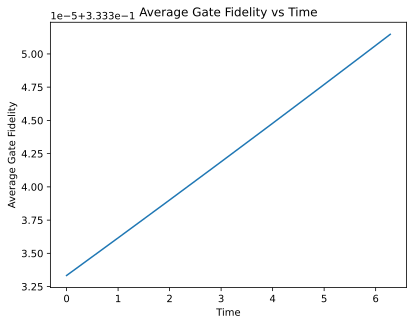

In [133]:
fid_times = []
fid_values = []

for i, t in enumerate(tqdm(times, desc='Calculating fidelity')):
    # U_t = P_list[i]

    #testing
    fid = qt.average_gate_fidelity(p_unitary[i], X_ideal)
    
    fid_times.append(t)
    fid_values.append(fid)

plt.plot(np.array(fid_times), np.array(fid_values))
plt.xlabel('Time')
plt.ylabel('Average Gate Fidelity')
plt.title('Average Gate Fidelity vs Time')
plt.show()

In [ ]:
peak_fidelity_noise = np.max(fid_values)
print("Peak average gate fidelity:", peak_fidelity_noise)

peak_index_noise = np.argmax(fid_values)
peak_time_noise = times[peak_index_noise]
print("Time at peak fidelity:", peak_time_noise)